### Assignment 12:  Clustering Text Embeddings Obtained from Fine-tuned Language Model
---
Name: Shiqi Hu

GTID: 904061372

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import json
import io
import re
import os
import ast
import pandas_datareader as pdr
from datetime import datetime
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from transformers import AdamW
from torch.optim import AdamW
from transformers import get_scheduler
from torch.optim.lr_scheduler import LinearLR
# from transformers import pipeline
from transformers import AutoConfig
from transformers import DataCollatorWithPadding
import torch.nn.functional as F
from datasets import Dataset as Dataset
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [11]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# If you are using a GPU, ensure reproducibility with CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### Step 1: Preparing the Dataset
---

**1. Gather business description of sampled companies**

In [12]:
# Extract business description data from json zip file
with open('D:/8803_D/A12/business_description_10K.zip', 'rb') as f:
    zip_file = zipfile.ZipFile(io.BytesIO(f.read()))

extracted_data = []

for filename in zip_file.namelist():
    if filename.endswith('.json'):
        with zip_file.open(filename) as file:
            content = json.load(file)
            relevant_info = {
                "filing_date": content.get("filing_date"),
                "item_1": content.get("item_1"),
                "PERMNO": content.get("PERMNO")
            }
            extracted_data.append(relevant_info)

business_description_df_raw = pd.DataFrame(extracted_data)

In [13]:
business_description_df = business_description_df_raw.copy()
business_description_df['filing_date'] =  pd.to_datetime(business_description_df['filing_date'] )
business_description_df['year'] = business_description_df['filing_date'].dt.to_period('Y')
business_description_df = business_description_df.sort_values('filing_date')

In [14]:
sample_df = pd.read_csv('sample_company.csv')

# Convert the 'PERMNO' column from a string representation to an actual list
sample_df['PERMNO'] = sample_df['PERMNO'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Expand the 'PERMNO' lists into separate rows
expanded_sample_df = sample_df.explode('PERMNO')

In [15]:
business_description_df['year'] = business_description_df['year'].astype(str)
expanded_sample_df['year'] = expanded_sample_df['year'].astype(str)
business_description_df['PERMNO'] = business_description_df['PERMNO'].astype(str)
expanded_sample_df['PERMNO'] = expanded_sample_df['PERMNO'].astype(str)

labled_business_description_df = pd.merge(business_description_df, expanded_sample_df, on=['year','PERMNO'], how='left')
labled_business_description_df = labled_business_description_df.dropna()

In [16]:
labled_business_description_df

,filing_date,item_1,PERMNO,year,label
2599,1996-02-23,ITEM 1. BUSINESS\nGENERAL The Company is a bui...,70092,1996,2.0
2709,1996-03-13,"ITEM 1. BUSINESS\nGeneral\nEMCOR Group, Inc. (...",82694,1996,4.0
2835,1996-03-22,ITEM 1. BUSINESS.\nGENERAL\nUSA Waste Services...,11955,1996,9.0
2844,1996-03-22,ITEM 1. DESCRIPTION OF BUSINESS\nPolaris Indus...,75182,1996,6.0
2962,1996-03-26,Item 1. Business.\nPrincipal Products\nThe reg...,16468,1996,0.0
...,...,...,...,...,...
110249,2022-12-13,"Item 1. Business\nAlico, Inc. (“Alico”) was in...",11790,2022,0.0
110274,2022-12-19,ITEM 1\nBUSINESS\nBusiness Overview\nHovnanian...,65285,2022,2.0
110275,2022-12-19,"ITEM 1. BUSINESS\nToll Brothers, Inc., a corpo...",70228,2022,2.0
110279,2022-12-20,Item 1. Business\nGeneral development of the b...,89447,2022,0.0


**2. Tokenize business description:**

In [17]:
tokenizer_BERT = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenizer_sent_BERT = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
tokenizer_LF = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
tokenizer_GPT2 = AutoTokenizer.from_pretrained('openai-community/gpt2')

In [18]:
texts = labled_business_description_df['item_1'].values
# labels = labled_business_description_df['label'].values 

In [19]:
# Tokenize with BERT
tokenized_data_BERT = tokenizer_BERT(
    texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=512,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [20]:
# Tokenize with sent_BERT
tokenized_data_sent_BERT = tokenizer_sent_BERT(
    texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=512,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [21]:
# Tokenize with LF
tokenized_data_LF = tokenizer_LF(
    texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=512,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [22]:
# Tokenize with GPT2
# For decoder-only model GPT-2, you need to specify pad_token as follow after loading:
tokenizer_GPT2.pad_token = tokenizer_GPT2.eos_token

tokenized_data_GPT2 = tokenizer_GPT2(
    texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=512,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [23]:
# look at first sample's tokens for validation
decoded_text_LF = tokenizer_LF.decode(tokenized_data_LF['input_ids'][0], skip_special_tokens=True)
print(decoded_text_LF)

decoded_text_GPT2 = tokenizer_GPT2.decode(tokenized_data_GPT2['input_ids'][0], skip_special_tokens=True)
print(decoded_text_GPT2)

ITEM 1. BUSINESS
GENERAL The Company is a builder of single-family homes with domestic operations in six western states, and international operations in France, Canada and Mexico. The Company is the largest home builder in the western United States and among the largest builders in greater metropolitan Paris, France. The Company builds and markets innovatively designed homes, generally in medium-sized developments close to major metropolitan areas, that cater primarily to first-time home buyers. In France, the Company is also a developer of commercial projects and high-density residential properties, such as condominium and apartment complexes. The Company also provides mortgage banking services to its domestic home buyers through its wholly owned subsidiary, Kaufman and Broad Mortgage Company ("KBMC").
The Company's business originated in 1957 and was operated through various subsidiaries of SunAmerica Inc. ("SunAmerica"), previously known as Kaufman and Broad Inc. or Broad Inc., unti

In [131]:
# tokenized_data_BERT['input_ids'][0]

**3. Split dataset into train, validattion, and test**

In [25]:
# Split the dataset into train (80%), validation (10%), and test (10%)
labels = labled_business_description_df['label'].astype(np.int64).values

# Extract components from the tokenized data
input_ids = tokenized_data_BERT['input_ids']
attention_masks = tokenized_data_BERT['attention_mask']

# Split input_ids and attention_masks, along with labels
train_input_ids, temp_input_ids, train_attention_masks, temp_attention_masks, train_labels, temp_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

val_input_ids, test_input_ids, val_attention_masks, test_attention_masks, val_labels, test_labels = train_test_split(
    temp_input_ids, temp_attention_masks, temp_labels, test_size=0.5, random_state=42
)

In [26]:
labels

array([2, 4, 9, ..., 2, 0, 7], dtype=int64)

In [27]:
# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels_tensor)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

### Step 2: Fine-tuning BERT
---
After fine-tuning BERT with provided hyper-parameter, the best validation F1 score is 0.7702.

In [28]:
# 1. Set up BERT model
BERT_model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=10,
    output_hidden_states=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# 2 & 3: Training using Hyper-parameters
def train_bert(model, train_loader, val_loader, epochs=10, learning_rate=5e-5):
    """
    BERT training function using DataLoader for batching
    
    Parameters:
    - model: BERT model
    - epochs: number of training epochs
    - batch_size: size of batches
    - learning_rate: learning rate for optimizer
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Calculate total steps for learning rate scheduler
    total_steps = len(train_loader) * epochs
    
    # Initialize scheduler
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': []
    }
    
    # Best model tracking
    best_f1 = 0.0
    
    try:
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            
            # Training phase
            model.train()
            total_train_loss = 0
            
            for batch in tqdm(train_loader, desc="Training"):
                batch = [item.to(device) for item in batch]
                input_ids, attention_mask, labels = batch
                
                # Clear gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                # Loss calculation
                loss = outputs.loss
                total_train_loss += loss.item()
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Update parameters
                optimizer.step()
                scheduler.step()
            
            # Average training loss for the epoch
            avg_train_loss = total_train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            
            # Validation phase
            model.eval()
            total_val_loss = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    batch = [item.to(device) for item in batch]
                    input_ids, attention_mask, labels = batch
                    
                    # Forward pass
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    
                    # Loss calculation
                    loss = outputs.loss
                    total_val_loss += loss.item()
                    
                    # Get predictions
                    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_labels.extend(labels.cpu().numpy())
            
            # Calculate validation metrics
            avg_val_loss = total_val_loss / len(val_loader)
            val_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            history['val_loss'].append(avg_val_loss)
            history['val_f1'].append(val_f1)
            
            # Print epoch results
            print(f"Epoch {epoch + 1} Results:")
            print(f"Average Training Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {avg_val_loss:.4f}")
            print(f"Validation F1 Score: {val_f1:.4f}")
            
            # Save best model
            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_f1': best_f1,
                }, 'best_model.pth')
                print(f"New best model saved with F1 score: {val_f1:.4f}")
    
    except KeyboardInterrupt:
        print("Training interrupted by user")
    
    print(f"Training completed. Best validation F1 score: {best_f1:.4f}")
    return history

# Example usage
history = train_bert(
    model=BERT_model,
    train_loader = train_loader,
    val_loader = valid_loader,
    epochs=10,
    learning_rate=5e-5
)


Using device: cuda

Epoch 1/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Results:
Average Training Loss: 1.6616
Validation Loss: 0.9446
Validation F1 Score: 0.7068
New best model saved with F1 score: 0.7068

Epoch 2/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Results:
Average Training Loss: 0.9119
Validation Loss: 0.7561
Validation F1 Score: 0.7442
New best model saved with F1 score: 0.7442

Epoch 3/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Results:
Average Training Loss: 0.6295
Validation Loss: 0.8568
Validation F1 Score: 0.7550
New best model saved with F1 score: 0.7550

Epoch 4/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Results:
Average Training Loss: 0.4233
Validation Loss: 0.8462
Validation F1 Score: 0.7463

Epoch 5/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Results:
Average Training Loss: 0.2753
Validation Loss: 0.9602
Validation F1 Score: 0.7523

Epoch 6/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Results:
Average Training Loss: 0.1922
Validation Loss: 1.0270
Validation F1 Score: 0.7669
New best model saved with F1 score: 0.7669

Epoch 7/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Results:
Average Training Loss: 0.1121
Validation Loss: 1.1369
Validation F1 Score: 0.7384

Epoch 8/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Results:
Average Training Loss: 0.0719
Validation Loss: 1.1247
Validation F1 Score: 0.7702
New best model saved with F1 score: 0.7702

Epoch 9/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Results:
Average Training Loss: 0.0528
Validation Loss: 1.1930
Validation F1 Score: 0.7631

Epoch 10/10


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Results:
Average Training Loss: 0.0380
Validation Loss: 1.1793
Validation F1 Score: 0.7502
Training completed. Best validation F1 score: 0.7702


**Plot training loss, validation loss, and validation metric (F1) over epochs**

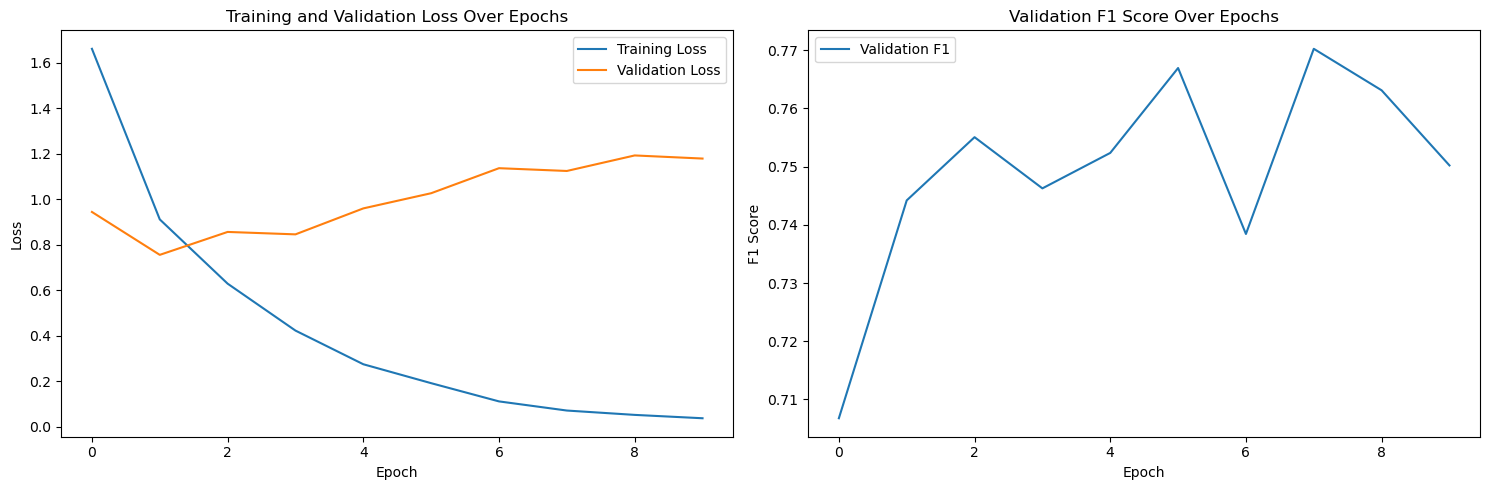

In [30]:
# 4. Statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot F1 score
ax2.plot(history['val_f1'], label='Validation F1')
ax2.set_title('Validation F1 Score Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.legend()

plt.tight_layout()
plt.savefig('fine_tune_bert_result.svg', format='svg')
plt.show()

### Step 3: Inference using Fine-tuned Models
---

In [31]:
class ModelInference:
    def __init__(self, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
    def load_models(self):
        """Load all required models and tokenizers"""
        # Dictionary to store models and tokenizers
        self.models = {}
        self.tokenizers = {}
        
        # 1. BERT (Load fine-tuned model)
        print("Loading BERT...")
        self.tokenizers['bert'] = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.models['bert'] = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=10,
            output_hidden_states=True
        )
        # Load saved weights
        checkpoint = torch.load('best_model.pth', map_location=self.device)
        self.models['bert'].load_state_dict(checkpoint['model_state_dict'])
        
        # 2. Sentence-BERT
        print("Loading Sentence-BERT...")
        self.tokenizers['sbert'] = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
        self.models['sbert'] = AutoModelForSequenceClassification.from_pretrained(
            "liqinye/sbert",
            num_labels=10,
            output_hidden_states=True
        )
        
        # 3. Longformer
        print("Loading Longformer...")
        self.tokenizers['longformer'] = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
        self.models['longformer'] = AutoModelForSequenceClassification.from_pretrained(
            "liqinye/longformer",
            num_labels=10,
            output_hidden_states=True
        )

        # 4. GPT-2
        print("Loading GPT-2...")
        self.tokenizers['gpt2'] = AutoTokenizer.from_pretrained("openai-community/gpt2")
        # For decoder-only model GPT-2, you need to specify pad_token as follow after loading:
        self.tokenizers['gpt2'].pad_token = self.tokenizers['gpt2'].eos_token
        self.models['gpt2'] = AutoModelForSequenceClassification.from_pretrained(
            "liqinye/gpt2",
            num_labels=10,
            output_hidden_states=True
        )
        
        # Move all models to device
        for model in self.models.values():
            model.to(self.device)
            model.eval()
    
    def get_embeddings(self, model_name, texts, batch_size=16):
        """
        Get embeddings from a specific model
        
        Parameters:
        - model_name: str, name of the model ('bert', 'sbert', 'longformer', 'gpt2')
        - texts: list of strings
        - batch_size: int, batch size for processing
        
        Returns:
        - embeddings: numpy array of embeddings
        - predictions: numpy array of predictions
        """
        model = self.models[model_name]
        tokenizer = self.tokenizers[model_name]
        
        all_embeddings = []
        all_predictions = []
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc=f"Getting {model_name} embeddings"):
                batch_texts = texts[i:i + batch_size]
                
                # Tokenize
                encodings = tokenizer(
                    batch_texts,
                    add_special_tokens=True,
                    max_length=512,
                    padding='max_length',
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt'
                )
                
                # Move to device
                input_ids = encodings['input_ids'].to(self.device)
                attention_mask = encodings['attention_mask'].to(self.device)
                
                # Get model outputs
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )
                
                # Get embeddings based on model type
                if model_name == 'gpt2':
                    # Use mean of last hidden state for GPT-2 embeddings
                    embeddings = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
                else:
                    # Use [CLS] token embedding for other models (first token of last layer)
                    embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
                
                # Get predictions
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1).cpu().numpy()
                
                all_embeddings.extend(embeddings)
                all_predictions.extend(predictions)
        
        return np.array(all_embeddings), np.array(all_predictions)
    
    def run_inference(self, texts, labels):
        """
        Run inference on all models and return results
        
        Parameters:
        - texts: list of strings
        - labels: numpy array of true labels
        
        Returns:
        - results_df: DataFrame with model performance metrics
        - embeddings_dict: Dictionary containing embeddings from each model
        """
        results = []
        embeddings_dict = {}
        
        for model_name in ['bert', 'sbert', 'longformer', 'gpt2']:
            print(f"\nProcessing {model_name}...")
            
            # Get embeddings and predictions
            embeddings, predictions = self.get_embeddings(model_name, texts)
            
            # Calculate metrics
            f1 = f1_score(labels, predictions, average='weighted')
            accuracy = accuracy_score(labels, predictions)
            
            results.append({
                'Model': model_name,
                'F1 Score': f1,
                'Accuracy': accuracy
            })
            
            # Store embeddings
            embeddings_dict[model_name] = embeddings
            
            print(f"{model_name} F1 Score: {f1:.4f}")
            print(f"{model_name} Accuracy: {accuracy:.4f}")
        
        # Create results DataFrame
        results_df = pd.DataFrame(results)
        
        return results_df, embeddings_dict

# Initialize inference
inference = ModelInference()
inference.load_models()

# Run inference
texts = texts.tolist() 
results_df, embeddings_dict = inference.run_inference(texts, labels)

Using device: None
Loading BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Sentence-BERT...


config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading Longformer...


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Loading GPT-2...

Processing bert...


Getting bert embeddings:   0%|          | 0/122 [00:00<?, ?it/s]

bert F1 Score: 0.9442
bert Accuracy: 0.9444

Processing sbert...


Getting sbert embeddings:   0%|          | 0/122 [00:00<?, ?it/s]

sbert F1 Score: 0.8335
sbert Accuracy: 0.8398

Processing longformer...


Getting longformer embeddings:   0%|          | 0/122 [00:00<?, ?it/s]

Initializing global attention on CLS token...


longformer F1 Score: 0.9099
longformer Accuracy: 0.9109

Processing gpt2...


Getting gpt2 embeddings:   0%|          | 0/122 [00:00<?, ?it/s]

gpt2 F1 Score: 0.9359
gpt2 Accuracy: 0.9356


In [32]:
# texts

**Report classification metric (F1 or Accuracy) for each model in a table.**

In [33]:
# Display results
print("\nModel Performance Comparison:")
results_df


Model Performance Comparison:


,Model,F1 Score,Accuracy
0,bert,0.944214,0.944359
1,sbert,0.833523,0.839773
2,longformer,0.909898,0.910871
3,gpt2,0.935901,0.935600


In [34]:
# Save embeddings
for model_name, embeddings in embeddings_dict.items():
    np.save(f'{model_name}_embeddings.npy', embeddings)
    print(f"Saved embeddings for {model_name}")

Saved embeddings for bert
Saved embeddings for sbert
Saved embeddings for longformer
Saved embeddings for gpt2


###  Step 4: Clustering using Embeddings
---

**Plot the embedding cluster for each model**

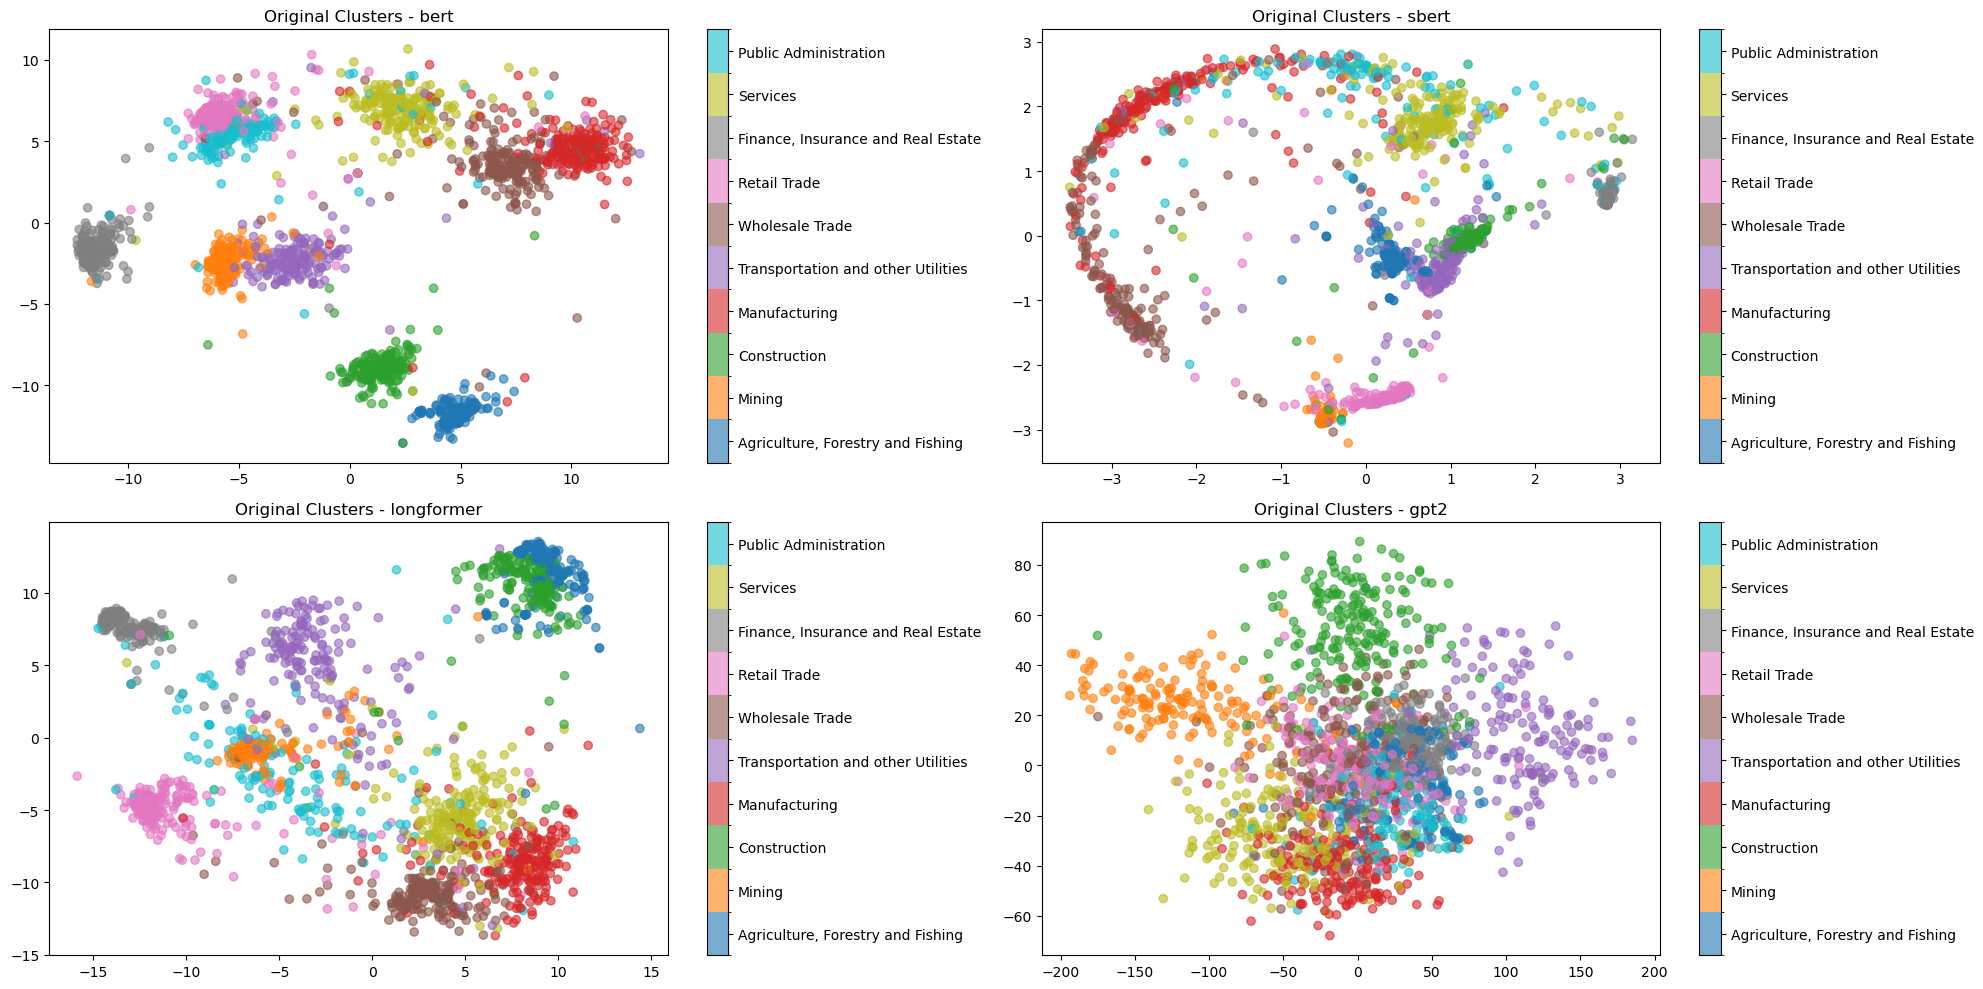

In [111]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define color map for industry labels
original_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
                                '#bcbd22', '#17becf'])
# Define boundary norms for labels (0 to 9)
original_norm = BoundaryNorm(np.arange(-0.5, 10), original_cmap.N)

# Industry label names
industry_labels = [
    "Agriculture, Forestry and Fishing", "Mining", "Construction", 
    "Manufacturing", "Transportation and other Utilities", "Wholesale Trade", 
    "Retail Trade", "Finance, Insurance and Real Estate", "Services", 
    "Public Administration"
]

# Plot original clusters with industry labels
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (model_name, embeddings) in enumerate(embeddings_dict.items()):
    # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Plot the clusters with the original labels
    scatter = axes[idx].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                                c=labels, cmap=original_cmap, norm=original_norm, alpha=0.6)
    axes[idx].set_title(f'Original Clusters - {model_name}')
    
    # Add color bar with industry labels as ticks
    cbar = plt.colorbar(scatter, ax=axes[idx], ticks=np.arange(10))
    cbar.ax.set_yticklabels(industry_labels)  # Set industry labels as tick labels

plt.tight_layout()
plt.savefig('original_clusters_plot.svg', format='svg')
plt.show()

In [112]:
# from matplotlib.colors import ListedColormap, BoundaryNorm
# # Define color maps for original labels
# original_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# # Define color norms
# original_norm = BoundaryNorm(np.arange(-0.5, 10), original_cmap.N)

# # 1. Visualize original clusters with PCA
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.ravel()
# for idx, (model_name, embeddings) in enumerate(embeddings_dict.items()):
#     # PCA
#     pca = PCA(n_components=2)
#     reduced_embeddings = pca.fit_transform(embeddings)
    
#     # Plot original clusters
#     scatter = axes[idx].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
#                                 c=labels, cmap=original_cmap, norm=original_norm, alpha=0.6)
#     axes[idx].set_title(f'Original Clusters - {model_name}')
#     plt.colorbar(scatter, ax=axes[idx], ticks=range(10))

# plt.tight_layout()
# plt.savefig('original_clusters_plot.svg', format='svg')
# plt.show()

#### Analyze the embedding cluster plots

**Based on the clustering visualization, which model do you think performs the best (i.e., which model’s embeddings are the most effective)? Is this consistent with its F1 score or accuracy?**
- BERT appears to perform the best based on both the embedding cluster separations and the evaluation metrics (F1 score: 0.94 and accuracy: 0.94). It shows relatively distinct clusters with a few overlapping areas. This consistency suggests that BERT embeddings are the most effective in capturing the separable structure of the data.

**What are your takeways when comparing decoder-only model embeddings with encoder-only model embeddings?**
- Decoder-Only Model (GPT-2): GPT-2, as a decoder-only model, generates embeddings that are more contextual and sequential. While it performs well, its embeddings show some overlap, possibly because decoder models are optimized for generation rather than distinguishing class boundaries. Additionally, the high overlap in GPT-2’s clusters might also be influenced by the PCA dimensionality reduction. Since GPT-2 embeddings capture many complex sequential dependencies, PCA might have removed some of these important features, leading to a loss in class-distinct information and resulting in clusters that appear more merged and less defined.
- Encoder-Only Models (BERT, SBERT, Longformer): Encoder models like BERT are optimized for extracting contextualized embeddings, which often capture distinctions between classes more effectively. BERT, in particular, shows clear separations between clusters, likely due to its bidirectional attention mechanism that excels at understanding relationships within the entire input context.

**Some clusters are distinct, while others overlap with each other. What does this overlap indicate?**
- Overlapping clusters indicate that certain embeddings are not easily distinguishable between classes. This overlap might mean that some classes are inherently similar in content or context, making it challenging for the model to differentiate them.
- For instance, Manufacturing and Wholesale Trade tend to overlap across models, as these sectors share characteristics, making them harder for the model to differentiate.
- This overlap may also highlight limitations in the model’s ability to capture subtle distinctions, indicating a need for further tuning to improve class separation.


**K-means Clustering Visualization**

In [36]:
# Perform K-means clustering on the embeddings with k=3 
def perform_kmeans_clustering(embeddings_dict):
    kmeans_results = {}
    
    for model_name, embeddings in embeddings_dict.items():
        kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
        kmeans_results[model_name] = kmeans.fit_predict(embeddings)
    
    return kmeans_results

# Perform K-means clustering
kmeans_results = perform_kmeans_clustering(embeddings_dict)

In [77]:
import pickle

# Save embeddings_dict
with open("embeddings_dict.pkl", "wb") as f:
    pickle.dump(embeddings_dict, f)

# Save kmeans_results
with open("kmeans_results.pkl", "wb") as f:
    pickle.dump(kmeans_results, f)

In [ ]:
# # Load embeddings_dict
# with open("embeddings_dict.pkl", "rb") as f:
#     embeddings_dict = pickle.load(f)

# # Load kmeans_results
# with open("kmeans_results.pkl", "rb") as f:
#     kmeans_results = pickle.load(f)

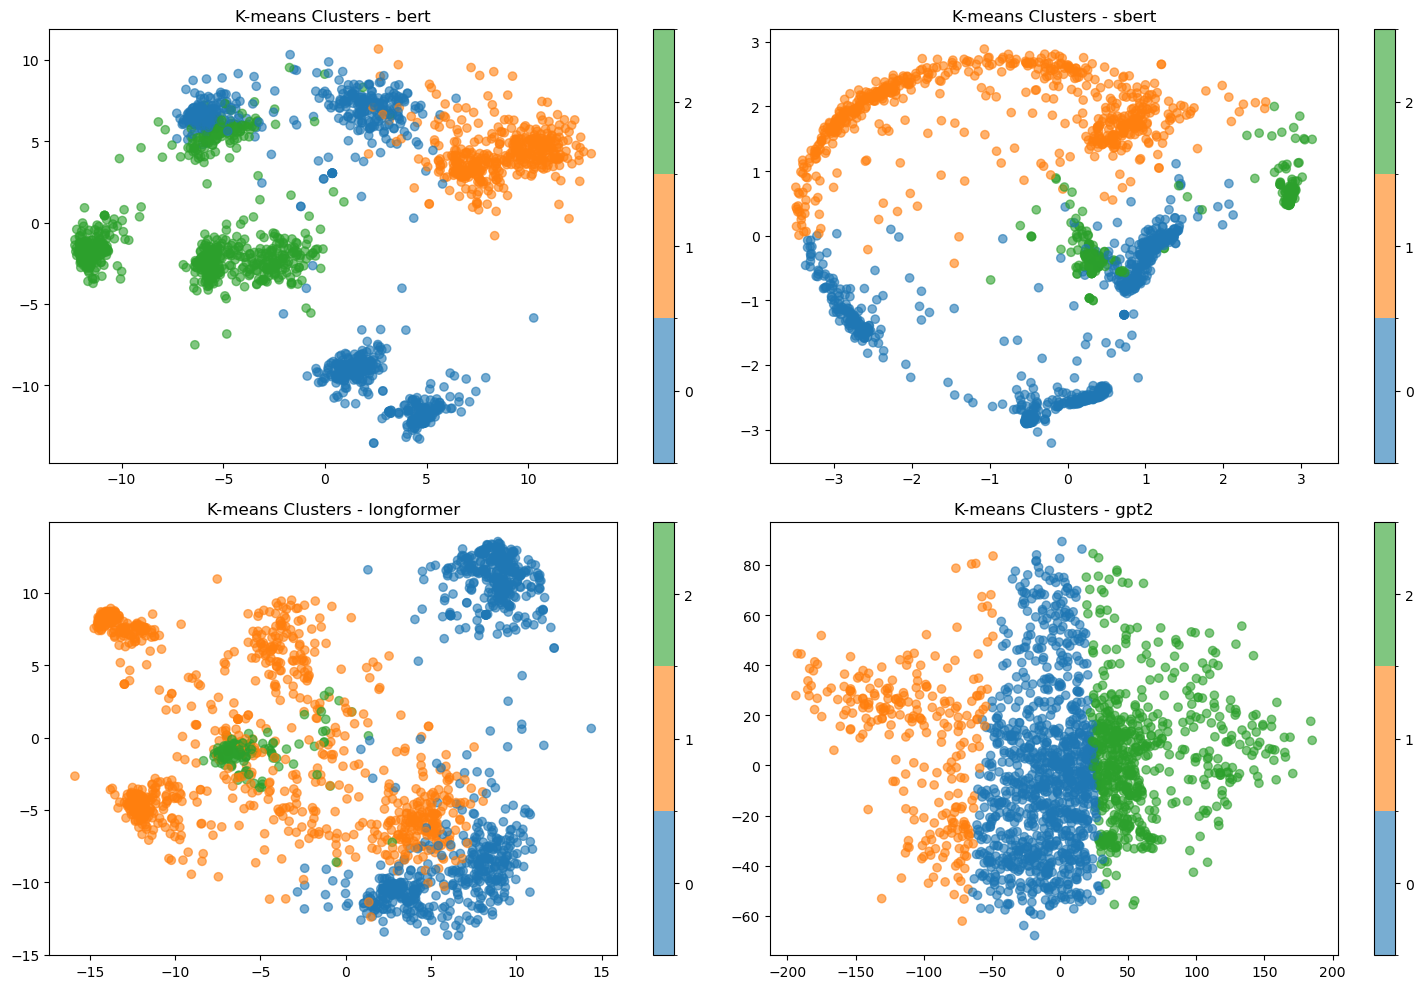

In [37]:
from matplotlib.colors import ListedColormap, BoundaryNorm
kmeans_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])
kmeans_norm = BoundaryNorm(np.arange(-0.5, 3), kmeans_cmap.N)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
for idx, (model_name, embeddings) in enumerate(embeddings_dict.items()):
    # PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Plot K-means clusters
    kmeans_labels = kmeans_results[model_name]
    scatter = axes[idx].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                                c=kmeans_labels, cmap=kmeans_cmap, norm=kmeans_norm, alpha=0.6)
    axes[idx].set_title(f'K-means Clusters - {model_name}')
    plt.colorbar(scatter, ax=axes[idx], ticks=[0, 1, 2])

plt.tight_layout()
plt.savefig('kmeans_plot.svg', format='svg')
plt.show()

#### Analyze the K-Means Cluster Plots (3 cluster centroids)

**Based on the K-Means clustering visualization, which model do you think performs the best? Is this consistent with its F1 score or accuracy?**
- GPT-2 shows the clearest separation with minimal overlap between the 3 clusters, suggesting it captures broad, distinct groupings effectively. 
- However, this clustering performance does not perfectly align with its slightly lower F1 score compared to BERT, indicating that while GPT-2 groups data well, BERT may still excel at fine-grained classification.

**What are your takeways when comparing decoder-only model embeddings with encoder-only model embeddings?**
- Decoder-only models like GPT-2 are effective at generating distinct groups in embeddings, which benefits broader clustering. 
- Encoder-only models (e.g., BERT) produce embeddings optimized for contextual distinctions, often enhancing accuracy in detailed classification tasks but not always achieving as clear separations in broader clusters.

**Some clusters are distinct, while others overlap with each other. What does this overlap indicate?**
- Overlapping clusters suggest some similarity or ambiguity between classes, which the model struggles to fully distinguish. This could indicate that certain classes may share overlapping characteristics, highlighting either natural similarities in the data or limitations in the model’s ability to separate subtle differences.

### Step 5: Portfolio Analysis
---
Regardless of the original 10 class PCA clustering, GPT-2 achieved the best cluster separation under K-Means clustering with K=3, it appears suitable for distinguishing between broader, high-level categories. The strong separation in the K-Means result suggests that GPT-2 embeddings capture underlying patterns or groupings that align well with the high-level clusters needed for portfolio analysis. So I choose GPT-2  for portfolio analysis.

In [107]:
labled_business_description_df['cluster'] = kmeans_results['gpt2']

In [ ]:
print('Clustered Business Descriptions:')
labled_business_description_df

Clustered Business Descriptions:


,filing_date,item_1,PERMNO,year,label,cluster
2599,1996-02-23,ITEM 1. BUSINESS\nGENERAL The Company is a bui...,70092,1996,2.0,0
2709,1996-03-13,"ITEM 1. BUSINESS\nGeneral\nEMCOR Group, Inc. (...",82694,1996,4.0,2
2835,1996-03-22,ITEM 1. BUSINESS.\nGENERAL\nUSA Waste Services...,11955,1996,9.0,2
2844,1996-03-22,ITEM 1. DESCRIPTION OF BUSINESS\nPolaris Indus...,75182,1996,6.0,0
2962,1996-03-26,Item 1. Business.\nPrincipal Products\nThe reg...,16468,1996,0.0,2
...,...,...,...,...,...,...
110249,2022-12-13,"Item 1. Business\nAlico, Inc. (“Alico”) was in...",11790,2022,0.0,2
110274,2022-12-19,ITEM 1\nBUSINESS\nBusiness Overview\nHovnanian...,65285,2022,2.0,0
110275,2022-12-19,"ITEM 1. BUSINESS\nToll Brothers, Inc., a corpo...",70228,2022,2.0,0
110279,2022-12-20,Item 1. Business\nGeneral development of the b...,89447,2022,0.0,2


In [121]:
# Load monthly return data
msf = pd.read_csv("D:\8803_D\A12\MSF_1996_2023.csv")
msf['date'] = pd.to_datetime(msf['date'], format='%Y-%m-%d')
msf['year'] = msf['date'].dt.year
msf['Month'] = msf['date'].dt.to_period('M')  # Monthly period for grouping
msf['RET'] = pd.to_numeric(msf['RET'], errors='coerce')
msf['vwretd'] = pd.to_numeric(msf['vwretd'], errors='coerce')
msf['MarketCap'] = msf['PRC'] * msf['SHROUT']

invalid_stocks = msf[msf['PRC'] < 0]['PERMNO'].unique()
msf = msf[~msf['PERMNO'].isin(invalid_stocks)]

# Calculate 1 + monthly returns for cumulative calculations
msf['1_plus_RET'] = 1 + msf['RET']
msf['1_plus_vwretd'] = 1 + msf['vwretd']

# Ensure data types match for merging
labled_business_description_df['PERMNO'] = pd.to_numeric(labled_business_description_df['PERMNO'], errors='coerce').astype('Int64')
labled_business_description_df['year'] = pd.to_numeric(labled_business_description_df['year'], errors='coerce').astype(np.int32)

# Merge labels directly into msf based on PERMNO and year
merged_df = pd.merge(msf, labled_business_description_df[['PERMNO', 'year', 'label', 'cluster']], on=['PERMNO', 'year'], how='inner')


In [122]:
print("Monthly msf data with cluster for selected companies:")
merged_df

Monthly msf data with cluster for selected companies:


,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,...,SHROUT,RETX,vwretd,year,Month,MarketCap,1_plus_RET,1_plus_vwretd,label,cluster
0,10019,1996-01-31,11,3610,IFRS,I F R SYSTEMS INC,7971,44950710,9.3750,11.875,...,5472.0,0.270270,0.028121,1996,1996-01,64296.000,1.270270,1.028121,3.0,0
1,10019,1996-02-29,11,3610,IFRS,I F R SYSTEMS INC,7971,44950710,11.6250,12.625,...,5472.0,0.042553,0.016353,1996,1996-02,67032.000,1.042553,1.016353,3.0,0
2,10019,1996-03-29,11,3610,IFRS,I F R SYSTEMS INC,7971,44950710,11.7500,13.750,...,5503.0,0.112245,0.010914,1996,1996-03,74978.375,1.112245,1.010914,3.0,0
3,10019,1996-04-30,11,3610,IFRS,I F R SYSTEMS INC,7971,44950710,12.6875,15.625,...,5503.0,0.137615,0.025560,1996,1996-04,85296.500,1.137615,1.025560,3.0,0
4,10019,1996-05-31,11,3610,IFRS,I F R SYSTEMS INC,7971,44950710,14.0000,16.000,...,5503.0,-0.048387,0.026810,1996,1996-05,81169.250,0.951613,1.026810,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300,93428,2012-08-31,11,9999,BSFT,BROADSOFT INC,53446,11133B40,23.8400,39.870,...,27590.0,0.474949,0.026317,2012,2012-08,999033.900,1.474949,1.026317,9.0,2
15301,93428,2012-09-28,11,9999,BSFT,BROADSOFT INC,53446,11133B40,37.2600,42.600,...,27811.0,0.132836,0.026513,2012,2012-09,1140807.220,1.132836,1.026513,9.0,2
15302,93428,2012-10-31,11,9999,BSFT,BROADSOFT INC,53446,11133B40,34.7400,40.010,...,27811.0,-0.068259,-0.014055,2012,2012-10,1062936.420,0.931741,0.985945,9.0,2
15303,93428,2012-11-30,11,9999,BSFT,BROADSOFT INC,53446,11133B40,29.8100,38.960,...,27835.0,-0.172423,0.006217,2012,2012-11,880421.050,0.827577,1.006217,9.0,2


In [123]:
# Initialize dictionary for storing portfolio returns
portfolios = {}

# Calculate portfolio returns by cluster for each month
for cluster in range(3):
    # Filter data by cluster
    portfolio_df = merged_df[merged_df['cluster'] == cluster]

    # Equal-Weighted Portfolio Returns: monthly average of returns within each cluster
    equal_weighted_returns = portfolio_df.groupby('Month')['RET'].mean()
    
    # Value-Weighted Portfolio Returns: weighted by MarketCap
    value_weighted_returns = portfolio_df.groupby('Month').apply(
        lambda x: np.sum(x['RET'] * x['MarketCap']) / np.sum(x['MarketCap'])
    )

    portfolios[f'Portfolio_{cluster}'] = {
        'EqualWeighted': equal_weighted_returns,
        'ValueWeighted': value_weighted_returns
    }

# Calculate cumulative monthly returns over the months
cumulative_returns = {}
for portfolio_name, returns in portfolios.items():
    cumulative_returns[portfolio_name] = {
        'EqualWeighted': (1 + returns['EqualWeighted']).cumprod() - 1,
        'ValueWeighted': (1 + returns['ValueWeighted']).cumprod() - 1
    }

# Calculate cumulative market return as a benchmark
market_return = msf.groupby('Month')['vwretd'].mean()
cumulative_market_return = (1 + market_return).cumprod() - 1

In [124]:
print('Cumulative Returns:')
cumulative_returns

Cumulative Returns:


{'Portfolio_0': {'EqualWeighted': Month
  1996-01    0.062298
  1996-02    0.066330
  1996-03    0.086639
  1996-04    0.103986
  1996-05    0.146954
               ...   
  2022-08    4.792494
  2022-09    4.082565
  2022-10    4.676993
  2022-11    4.896639
  2022-12    4.756046
  Freq: M, Name: RET, Length: 324, dtype: float64,
  'ValueWeighted': Month
  1996-01      0.025025
  1996-02      0.021245
  1996-03      0.047773
  1996-04      0.057906
  1996-05      0.102764
                ...    
  2022-08    138.289039
  2022-09    127.465530
  2022-10    142.696304
  2022-11    151.870974
  2022-12    144.274516
  Freq: M, Length: 324, dtype: float64},
 'Portfolio_1': {'EqualWeighted': Month
  1996-01   -0.046667
  1996-02   -0.093334
  1996-03   -0.072934
  1996-04    0.146765
  1996-05    0.249030
               ...   
  2022-08    0.035453
  2022-09   -0.058957
  2022-10    0.180781
  2022-11    0.191237
  2022-12    0.095449
  Freq: M, Name: RET, Length: 324, dtype: float64,
  'V

In [125]:
# Convert the index of cumulative returns to datetime for plotting
for portfolio_name, returns in cumulative_returns.items():
    returns['EqualWeighted'].index = returns['EqualWeighted'].index.to_timestamp()
    returns['ValueWeighted'].index = returns['ValueWeighted'].index.to_timestamp()

# Convert the index of cumulative market return to datetime for plotting
cumulative_market_return.index = cumulative_market_return.index.to_timestamp()

In [126]:
# Industry label mapping dictionary
industry_label_map = {
    0: "Agriculture, Forestry and Fishing",
    1: "Mining",
    2: "Construction",
    3: "Manufacturing",
    4: "Transportation and other Utilities",
    5: "Wholesale Trade",
    6: "Retail Trade",
    7: "Finance, Insurance and Real Estate",
    8: "Services",
    9: "Public Administration"
}

# Filter each cluster
filter_0 = merged_df[merged_df['cluster'] == 0]
filter_1 = merged_df[merged_df['cluster'] == 1]
filter_2 = merged_df[merged_df['cluster'] == 2]

# Count the occurrences of each unique label in each cluster and map to industry names
label_counts_0 = filter_0['label'].map(industry_label_map).value_counts()
label_counts_1 = filter_1['label'].map(industry_label_map).value_counts()
label_counts_2 = filter_2['label'].map(industry_label_map).value_counts()

# Display the result with industry names
print(f'Industry label counts for cluster = 0: \n{label_counts_0}')
print(f'Industry label counts for cluster = 1: \n{label_counts_1}')
print(f'Industry label counts for cluster = 2: \n{label_counts_2}')


Industry label counts for cluster = 0: 
label
Manufacturing                         1692
Retail Trade                          1441
Wholesale Trade                       1384
Construction                          1250
Services                              1046
Public Administration                  619
Agriculture, Forestry and Fishing      581
Finance, Insurance and Real Estate     364
Mining                                  96
Transportation and other Utilities      64
Name: count, dtype: int64
Industry label counts for cluster = 1: 
label
Mining                               1285
Services                              580
Construction                          156
Wholesale Trade                        96
Manufacturing                          84
Retail Trade                           48
Public Administration                  12
Agriculture, Forestry and Fishing      12
Name: count, dtype: int64
Industry label counts for cluster = 2: 
label
Transportation and other Utilities    1477
F

**Equal Weighted Portfolio Cumulative Returns vs Market Plot**

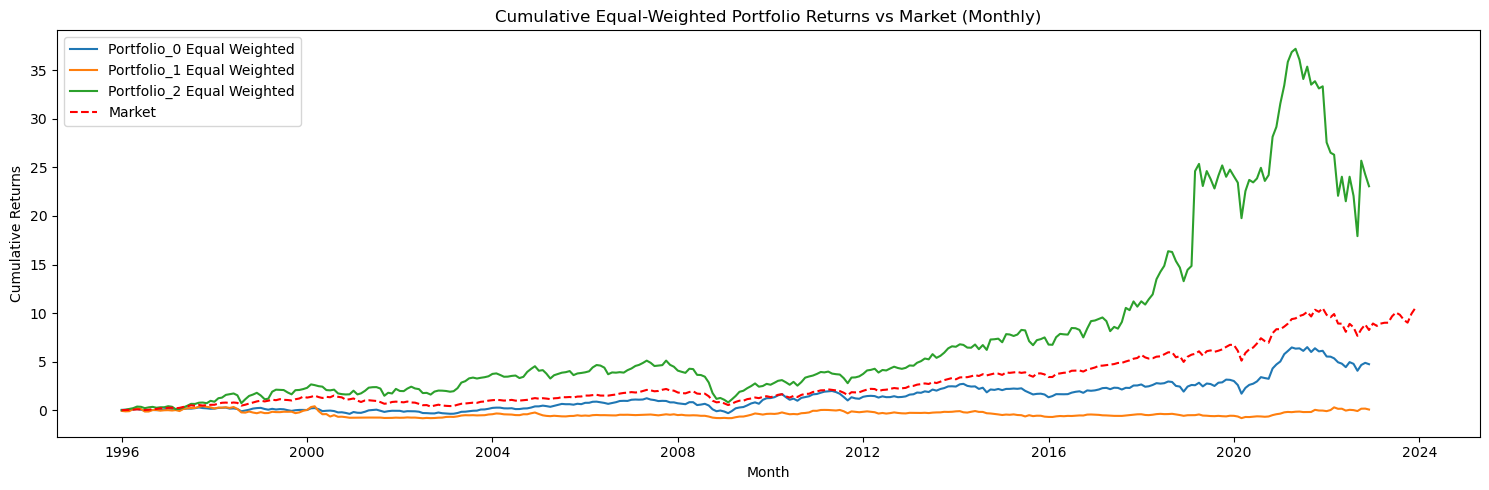

In [129]:
# Plot cumulative returns for Equal-Weighted Portfolios
plt.figure(figsize=(15, 5))
for portfolio_name, returns in cumulative_returns.items():
    plt.plot(returns['EqualWeighted'], label=f'{portfolio_name} Equal Weighted')

# Plot cumulative market return as a benchmark
plt.plot(cumulative_market_return, label='Market', color='red', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Equal-Weighted Portfolio Returns vs Market (Monthly)')
plt.legend()
plt.tight_layout()
plt.savefig("cum_ret_equal_monthly.svg", format="svg") 
plt.show()

#### Provide Comments on What You Observe from Equal Weighted Portfolio Cumulative Returns vs Market Plot

**Portfolio Performance Relative to Market:**

- Portfolio 2 outperformed both the market and the other portfolios,showing a significant rise in cumulative returns, particularly after 2017.
- Portfolio 0 consistently underperformed compared to the market, with returns generally below the market trend throughout the observed period.  
- Portfolio 1 also underperformed compared to the market, showing relatively flat returns over time.


**Industry Composition and Performance Implications:**

- Portfolio 2 has a high concentration in sectors like Transportation and other Utilities & Finance, Insurance and Real Estate, which might have contributed to its strong performance, especially if these sectors experienced growth in the observed period.
- Portfolio 0 includes significant representation from Manufacturing , Wholesale Trade, and Retail Trade. Despite having a balanced mix, the industries in this portfolio underperformed relative to the market, possibly due to slowdowns in traditional manufacturing or wholesale trade.
- Portfolio 1 contains a large number of Mining stocks, which might have contributed to its underperformance, as the mining sector can be volatile and dependent on global commodity cycles.


**Value Weighted Portfolio Cumulative Returns vs Market Plot**

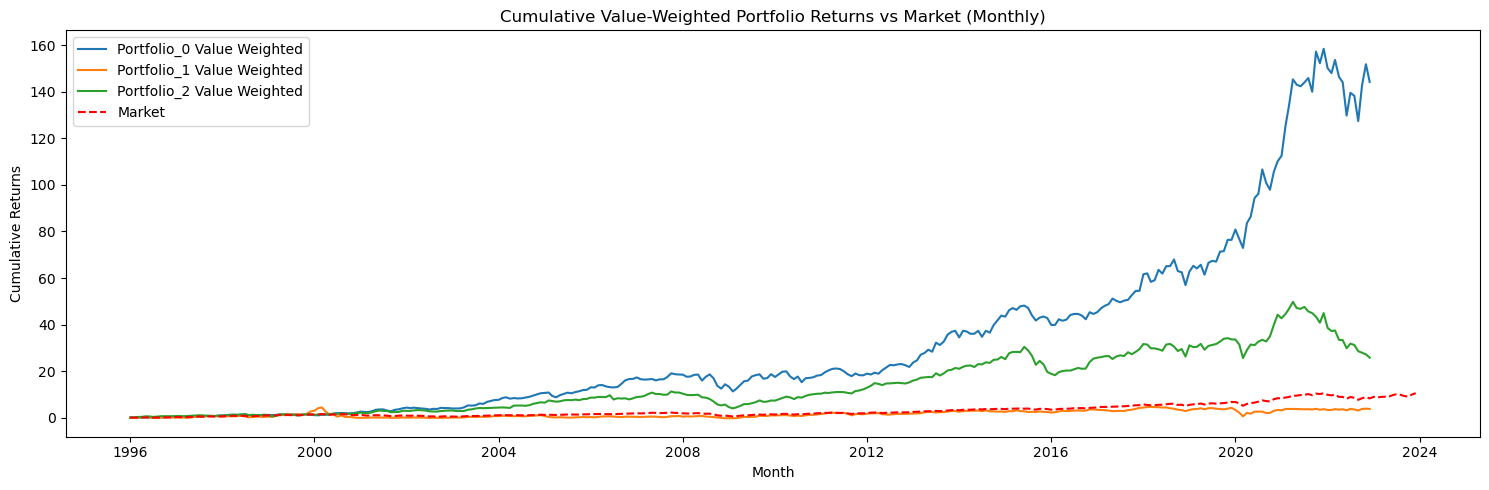

In [130]:
# Plot cumulative returns for Value-Weighted Portfolios
plt.figure(figsize=(15, 5))
for portfolio_name, returns in cumulative_returns.items():
    plt.plot(returns['ValueWeighted'], label=f'{portfolio_name} Value Weighted')

# Plot cumulative market return as a benchmark
plt.plot(cumulative_market_return, label='Market', color='red', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Value-Weighted Portfolio Returns vs Market (Monthly)')
plt.legend()
plt.tight_layout()
plt.savefig("cum_ret_value_monthly.svg", format="svg") 
plt.show()

#### Provide Comments on What You Observe from Value Weighted Portfolio Cumulative Returns vs Market Plot

**Portfolio Performance Relative to Market:**

- Portfolio 0 significantly outperformed both the market and the other portfolios, especially from 2016 onwards, indicating that larger companies in this portfolio drove substantial growth.
- Portfolio 2 also performed better than the market but with less pronounced growth than Portfolio 0.
- Portfolio 1 had the weakest performance, remaining relatively flat over time with returns generally tracking below the market.


**Industry Composition and Performance Implications Under Value-Weighting:**

- In a value-weighted portfolio, larger-cap companies have more influence on performance. The strong outperformance of Portfolio 0 suggests that this portfolio includes high-performing large-cap companies, possibly in sectors like Manufacturing and Retail, which had robust growth in recent years.
- Portfolio 1, with a high concentration in Mining, may have struggled due to market volatility in that sector, with larger companies in this portfolio not performing well over the observed period.
